# EBMR with product of coefficients

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

### About

The idea here is to iteratively multiply the coefficients in a ridge regression to induce sparsity. The implementation here is based on the work of Matthew Stephens ([see here](https://stephens999.github.io/misc/mr.ash_ridge.html)).

We consider the following hierarchical Empirical Bayes (EB) regression model:

$p\left(\mathbf{y} \mid \mathbf{W}, \mathbf{b}, \sigma\right) = N\left(\mathbf{y} \mid \mathbf{X}\mathbf{W}\mathbf{b}, \sigma^2 I_n\right)$

$p\left(\mathbf{b} \mid \sigma, \sigma_b\right) = N\left(\mathbf{b} \mid 0, \sigma^2 \sigma_b^2\right)$

$p\left(w_j \mid g\right) = g \in \mathcal{G}.$

where $\mathbf{W}$ is diagonal matrix whose diagonal elements are given by $(w_1,\dots,w_p)$, $\sigma, \sigma_b$ are scalars, and $g$ is a prior distribution that is to be estimated. The motivation is that the product of two normals will be distributed as a linear combination of two chi-square random variables.

$wb = \displaystyle\frac{1}{4}(w + b)^2 - \frac{1}{4}(w - b)^2$

By iteratively multiplying the $b$ coefficients on $w$, we can get sparse coefficients.

In [1]:
#collapse

import numpy as np
import pandas as pd
from scipy import linalg as sc_linalg
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ebmrPy/")
from inference.ebmr import EBMR
from inference import f_elbo
from inference import f_sigma
from inference import penalized_em
from utils import log_density

sys.path.append("../../utils/")
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

### Toy model

I am using the trend-filtering example as a toy model, following the work of Matthew. 

In [2]:
#collapse

def standardize(X):
    Xnorm = (X - np.mean(X, axis = 0)) 
    #Xstd =  Xnorm / np.std(Xnorm, axis = 0)
    Xstd = Xnorm / np.sqrt((Xnorm * Xnorm).sum(axis = 0))
    return Xstd

def trend_data(n, p, bval = 1.0, sd = 1.0, seed=100):
    np.random.seed(seed)
    X = np.zeros((n, p))
    for i in range(p):
        X[i:n, i] = np.arange(1, n - i + 1)
    btrue = np.zeros(p)
    idx = int(n / 3)
    btrue[idx] = bval
    btrue[idx + 1] = -bval
    y = np.dot(X, btrue) + np.random.normal(0, sd, n)
    # y = y / np.std(y)
    return X, y, btrue

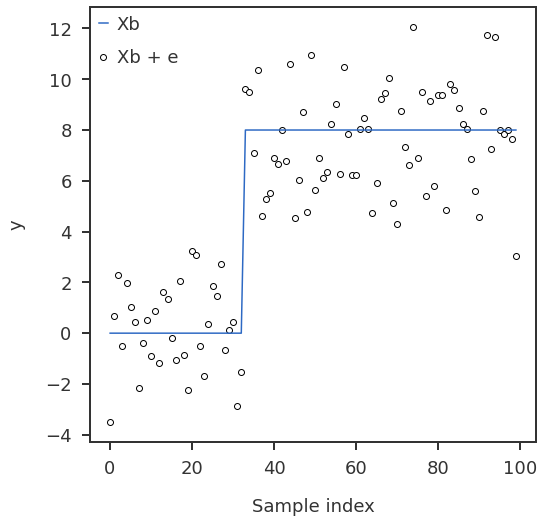

In [3]:
#collapse-show

n = 100
p = 200
bval = 8.0
sd = 2.0
X, y, btrue = trend_data(n, p, bval = bval, sd = sd)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(n), np.dot(X, btrue), label="Xb")
ax1.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white', label="Xb + e")
ax1.legend()
ax1.set_xlabel("Sample index")
ax1.set_ylabel("y")
plt.show()

### Ridge regression using EM

First, I will try normal ridge regression:

$p\left(\mathbf{y} \mid \mathbf{b}, \sigma^2\right) = N\left(\mathbf{y} \mid \mathbf{X}\mathbf{b}, \sigma^2 \mathbb{I}_n\right)$

$p\left(\mathbf{b} \mid \sigma_b^2\right) = N\left(\mathbf{b} \mid 0, \sigma_b^2 \mathbb{I}_p \right)$

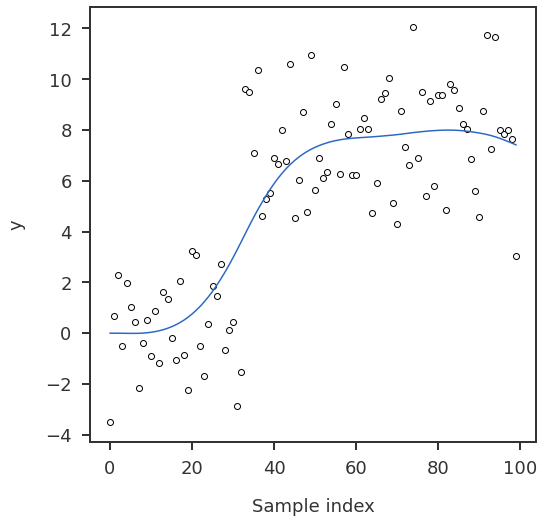

In [4]:
# collapse

m1 = penalized_em.ridge(X, y, 1.0, 1.0,
                        max_iter=4000, tol=1e-8, ignore_convergence=False)

m1_bpred = m1[2]

m1_ypred = np.dot(X, m1_bpred)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(n), m1_ypred)
ax1.set_xlabel("Sample index")
ax1.set_ylabel("y")

plt.show()

### Iterative ridge regression

Next, I will try iterative ridge regression, using:

$p\left(\mathbf{y} \mid \mathbf{b}, \sigma^2\right) = N\left(\mathbf{y} \mid \mathbf{X}\mathbf{W}\mathbf{b}, \sigma^2 \mathbb{I}_n\right)$

$p\left(\mathbf{b} \mid \sigma_b^2\right) = N\left(\mathbf{b} \mid 0, \sigma_b^2 \mathbb{I}_p \right)$.

$\mathbf{W}$ is a diagonal matrix whose diagonal elements are given by $\mathbf{w} := (w_1,\dots,w_p)$.
In every step, we perform EM ridge regression using $\mathbf{X}\mathbf{W}$ as the predictor variable. We update $\mathbf{w}_{\mathrm{new}} = \mathbf{w}_{\mathrm{old}} \mathbf{b}$. The iteration stops when the marginal likelihood given by 

$p\left(\mathbf{y} \mid \mathbf{W}, \sigma^2, \sigma_b^2 \right) = N\left(\mathbf{y} \mid 0, \sigma^2\mathbb{I}_n + \sigma_b^2\mathbf{X}\mathbf{W}(\mathbf{X}\mathbf{W})^{\mathsf{T}} \right)$

converges to a tolerance value (`tol`). Here, we obtain a point estimate of $\mathbf{W}$. We have not set any prior on $\mathbf{W}$ explicitly. Since $\mathbf{b}$ has a Gaussian prior, we can think of $\mathbf{W}$ as having an implicit prior of a product of $T$ Gaussians (where $T$ is the number of iterations). 

In [5]:
#collapse-hide

def ridge_step(X, y, s2, sb2, W):
    n, p = X.shape
    Xscale = np.dot(X, np.diag(W))
    XTX = np.dot(Xscale.T, Xscale)
    XTy = np.dot(Xscale.T, y)
    yTy = np.dot(y.T, y)
    
    sigmabinv = (XTX + np.eye(p) * (s2 / sb2)) / s2
    sigmab = np.linalg.inv(sigmabinv) # posterior variance of b
    mub = np.dot(sigmab, XTy) / s2 # posterior mean of b
    
    mmT = np.einsum('i,j->ij', mub, mub)
    BTB = mmT + sigmab
    XWmu = np.dot(Xscale, mub)
    s2  = (np.sum(np.square(y - XWmu)) + np.trace(np.dot(XTX, sigmab))) / n
    sb2 = np.trace(BTB) / p
    return s2, sb2, mub


def ridge_mll(X, y, s2, sb2, W):
    n, p = X.shape
    Xscale = np.dot(X, np.diag(W))
    XWWtXt = np.dot(Xscale, Xscale.T)
    sigmay = s2 * (np.eye(n) + sb2 * XWWtXt)
    muy    = np.zeros((n, 1))
    return log_density.mgauss(y.reshape(-1,1), muy, sigmay)


def iterative_ridge(X, y,
                    s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
                    max_iter = 1000, tol = 1e-8):

    n_samples, n_features = X.shape
    mll_path = np.zeros(max_iter + 1)
    W = np.ones(n_features)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    mll_path[0] = ridge_mll(X, y, s2, sb2, W)
    
    '''
    Iterations
    '''
    for itn in range(1, max_iter + 1):
        s2, sb2, mub = ridge_step(X, y, s2, sb2, W)
        W *= mub
        
        '''
        Convergence
        '''
        niter += 1
        mll_path[itn] = ridge_mll(X, y, s2, sb2, W)
        if mll_path[itn] - mll_path[itn - 1] < tol: break

    return s2, sb2, mub, W, niter, mll_path[:niter + 1]

This gives a sparse solution and a better prediction than ridge regression.

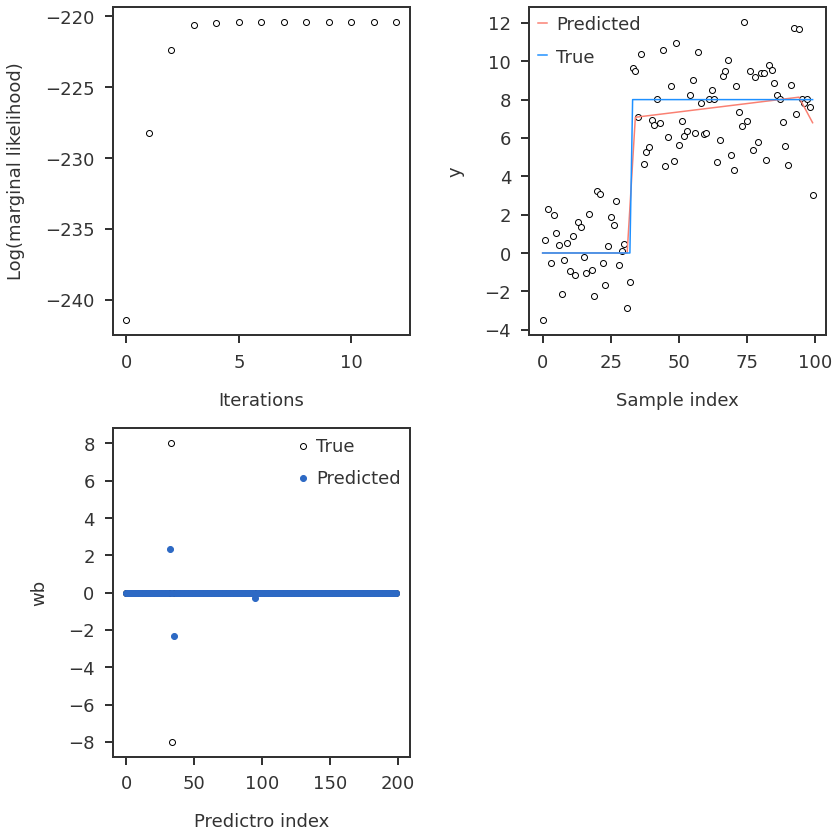

In [6]:
#collapse-hide

m2 = iterative_ridge(X, y, s2_init = 3.0)

_, _, bpred, W, niter, mll_path = m2
ypred = np.dot(X, W)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

yvals = mll_path[1:]
ax1.scatter(np.arange(niter), yvals, edgecolor = 'black', facecolor='white')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Log(marginal likelihood)")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), W, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictro index")
ax3.set_ylabel("wb")

plt.tight_layout()
plt.show()

### Approximate ELBO in the iterative framework

In the iterative framework, the prior on $\mathbf{W}$ is essentialy a product of $T$ normals, where $T$ is the number of iterations. We can think of the above problem in the framework of variational approximation and try to calculate the ELBO $F\left(q(\mathbf{b}, \mathbf{W}) \right)$. 

However, we do not know the $\mathbb{E}_{q(\mathbf{W})} \left[ \ln g(\mathbf{W}) \right]$ and $\mathbb{E}_{q(\mathbf{W})} \left[ \ln q(\mathbf{W}) \right]$. Hence, I calculated an approximate ELBO by considering $\mathbb{E}_{q(w)} \left[ \ln (g(\mathbf{W}) / q(\mathbf{W})) \right] = 0$. Derivations are still in my notebook.

I find that the approximate ELBO is very close to the evidence $p\left( \mathbf{y} \mid \mathbf{W}, \sigma^2, \sigma_b^2 \right)$.

In [7]:
#collapse-hide

def elbo(X, y, s2, sb2, mub, sigmab, Wbar, varWj, XTX, KLqW):
    '''
    Wbar is a vector which contains the diagonal elements of the diagonal matrix W
    W = diag_matrix(Wbar)
    Wbar = diag(W)
    --
    VW is a vector which contains the diagonal elements of the diagonal matrix V_w
    '''
    n, p = X.shape
    VW = np.diag(XTX) * varWj
    elbo = c_func(n, p, s2, sb2) \
           + h1_func(X, y, s2, sb2, mub, Wbar, VW) \
           + h2_func(p, s2, sb2, XTX, sigmab, Wbar, VW) \
           - KLqW
    return elbo
    
def c_func(n, p, s2, sb2):
    val  =   0.5 * p 
    val += - 0.5 * p * np.log(sb2)
    val += - 0.5 * n * np.log(2.0 * np.pi * s2)
    return val

def h1_func(X, y, s2, sb2, mub, Wbar, VW):
    XWmu = np.linalg.multi_dot([X, np.diag(Wbar), mub])
    val1 = - (0.5 / s2) * np.sum(np.square(y - XWmu))
    val2 = - 0.5 * np.sum(np.square(mub) * ((VW / s2) + (1 / sb2)))
    val  = val1 + val2
    return val

def h2_func(p, s2, sb2, XTX, sigmab, Wbar, VW):
    (sign, logdet) = np.linalg.slogdet(sigmab)
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    val  =   0.5 * logdet
    val += - 0.5 * np.dot(WtXtXW + np.diag(VW) + np.eye(p) * (s2 / sb2), sigmab).trace() / s2
    return val

def grr_b(X, y, s2, sb2, Wbar, varWj, XTX, XTy):
    n, p = X.shape
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    VW = np.diag(XTX) * varWj
    
    sigmabinv = (WtXtXW + np.diag(VW) + np.eye(p) * s2 / sb2) / s2
    sigmab = np.linalg.inv(sigmabinv)
    mub = np.linalg.multi_dot([sigmab, W, XTy]) / s2
    
    XWmu = np.linalg.multi_dot([X, W, mub])
    mub2 = np.square(mub)
    s2 = (np.sum(np.square(y - XWmu)) + np.dot((WtXtXW + np.diag(VW)), sigmab).trace() \
          + np.sum(mub2 * VW)) / n
    sb2 = (np.sum(mub2) + sigmab.trace()) / p
    return s2, sb2, mub, sigmab

def grr_W_point(X, y, s2, sw2, mub, sigmab, muWj, sigmaWj2, XTX, XTy):
    muWj = muWj * mub
    sigmaWj2 = np.zeros(p)
    #sigmaWj2 = sigmaWj2 * np.diag(sigmab)
    KLqW = 0.0
    return sw2, muWj, sigmaWj2, KLqW
    

def ebmr_iterative_ridge(X, y,
            s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
            w_init = None,
            max_iter = 1000, tol = 1e-8
           ):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    n_samples, n_features = X.shape
    elbo_path = np.zeros(max_iter + 1)
    mll_path = np.zeros(max_iter + 1)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    sw2 = sw2_init
    mub = np.zeros(n_features)
    sigmab = np.zeros((n_features, n_features))
    if w_init is None:
        muWj = np.ones(n_features)
    else:
        muWj = w_init
    sigmaWj2 = np.zeros(n_features)
    elbo_path[0] = -np.inf
    mll_path[0] = -np.inf
    KLqW = 0
    
    for itn in range(1, max_iter + 1):
        '''
        GRR for b
        '''
        s2, sb2, mub, sigmab = grr_b(X, y, s2, sb2, muWj, sigmaWj2, XTX, XTy)
        #print(itn, s2, sb2, mub[0])
        
        '''
        GRR for W
        '''
        sw2, muWj, sigmaWj2, KLqW = grr_W_point(X, y, s2, sw2, mub, sigmab, muWj, sigmaWj2, XTX, XTy)
        
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = elbo(X, y, s2, sb2, mub, sigmab, muWj, sigmaWj2, XTX, KLqW)
        mll_path[itn] = ridge_mll(X, y, s2, sb2, muWj)
        #if elbo_path[itn] - elbo_path[itn - 1] < tol: break
        if mll_path[itn] - mll_path[itn - 1] < tol: break
    return s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, niter, elbo_path[:niter + 1], mll_path[:niter + 1]

This gives a solution similar to the iterative ridge regression, except that the predicted values of the coefficients are better. However, the approximate ELBO behaves strangely, which is quite expected because it is not a true ELBO. 

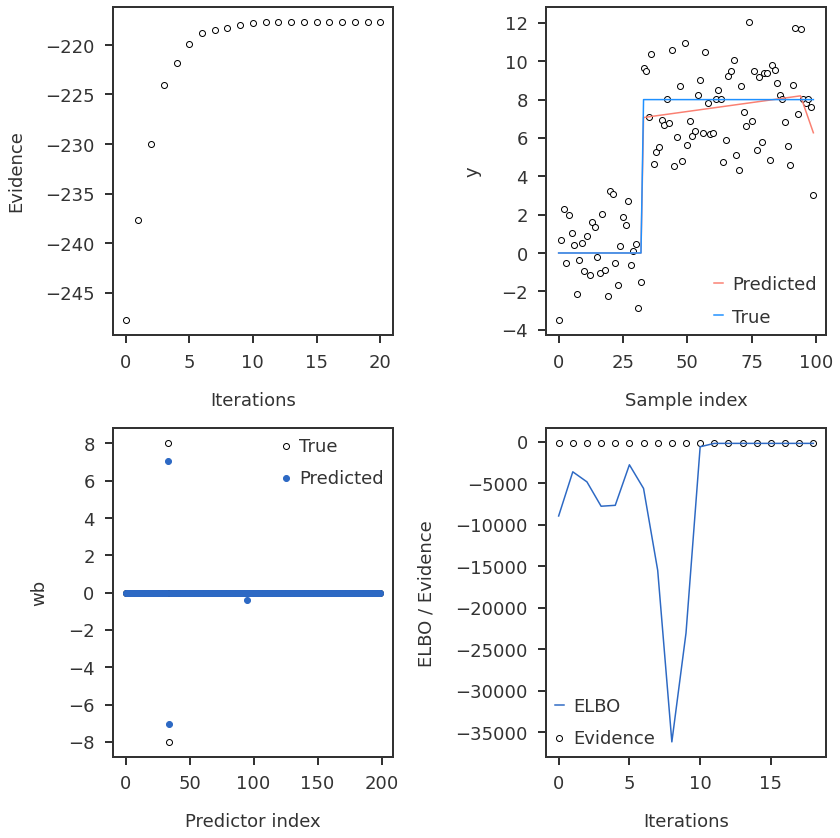

In [8]:
#collapse-hide
m3 = ebmr_iterative_ridge(X, y, max_iter = 200)

_, _, _, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m3
ypred = np.dot(X, W)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.arange(niter), mll_path[1:], edgecolor = 'black', facecolor='white')
#ax1.plot(np.arange(niter), elbo_path[1:])
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Evidence")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), W, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictor index")
ax3.set_ylabel("wb")

nstep = min(80, niter - 2)
ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
ax4.legend()
ax4.set_xlabel("Iterations")
ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

###  Product of two normals

Instead of using a product of multiple normals, we can restrict the coefficients $\mathbf{W}\mathbf{b}$ to a product of two normals, and iterate between solving $\mathbf{W}$ and $\mathbf{b}$.

$p\left(\mathbf{y} \mid \mathbf{b}, \sigma^2\right) = N\left(\mathbf{y} \mid \mathbf{X}\mathbf{W}\mathbf{b}, \sigma^2 \mathbb{I}_n\right) = N\left(\mathbf{y} \mid \mathbf{X}\mathbf{B}\mathbf{w}, \sigma^2 \mathbb{I}_n\right)$

$p\left(\mathbf{b} \mid \sigma_b^2\right) = N\left(\mathbf{b} \mid 0, \sigma_b^2 \mathbb{I}_p \right)$

$\displaystyle p\left(\mathbf{w} \mid \sigma_w^2\right) = \prod_{j=1}^{P} N\left(w_j \mid 0, \sigma_w^2 \mathbb{I}_p \right)$.

As before $\mathbf{W}$ is a $p \times p$ diagonal matrix whose diagonal elements are given by $w_j$. The vector of $\{w_j\}$ is denoted as $\mathbf{w}$. Here I introduced the matrix $\mathbf{B}$ which is required when solving for $\mathbf{w}$. $\mathbf{B}$ is a $p \times p$ diagonal matrix whose diagonal elements are given by $b_j$. I used the following factorization:

$\displaystyle q\left(\mathbf{b}, \mathbf{w}\right) = q\left(\mathbf{b}\right) \prod_{j=1}^{P}q_j\left(w_j\right) $.

We can separate the problem to two steps. In the first step, we assume $\mathbf{W}$ is known and solve for $\mathbf{b}$. In the second step, we assume $\mathbf{B}$ is known and solve for $\mathbf{w}$. We continue iterating until we reach convergence. 

For the first step, the updates should be the same as for normal ridge regression with fixed $\mathbf{W}$:

$p\left(\mathbf{b} \mid \mathbf{y}, \mathbf{W}, \sigma^2, \sigma_b^2 \right) = N\left( \mathbf{b} \mid \mathbf{m}, \mathbf{S}\right)$,

$\displaystyle \mathbf{S} = \left[ \frac{1}{\sigma^2}\mathbf{W}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{W} + \frac{1}{\sigma_b^2}\mathbb{I} \right]^{-1}$,

$\displaystyle \mathbf{m} = \frac{1}{\sigma^2} \mathbf{S}\mathbf{W}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{y}$,

$\displaystyle \sigma^2 = \frac{1}{N} \left\{ \left\Vert \mathbf{y} - \mathbf{X}\mathbf{W}\mathbf{m} \right\Vert_{2}^{2} + \mathrm{Tr}\left(\mathbf{W}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{W}\mathbf{S} \right) \right\}$, 

$\displaystyle \sigma_b^2 = \frac{1}{P} \mathrm{Tr}\left(\mathbf{m}\mathbf{m}^{\mathsf{T}} + \mathbf{S}\right)$ 


Similarly, we have another ridge regression for $\mathbf{W}$ with

$p\left(\mathbf{w} \mid \mathbf{y}, \mathbf{B}, \sigma^2, \sigma_w^2 \right) = N\left( \mathbf{w} \mid \mathbf{a}, \mathbf{V}\right)$,

$\displaystyle \mathbf{V} = \left[ \frac{1}{\sigma^2}\mathbf{B}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{B} + \frac{1}{\sigma_w^2}\mathbb{I} \right]^{-1}$,

$\displaystyle \mathbf{a} = \frac{1}{\sigma^2} \mathbf{V}\mathbf{B}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{y}$,

$\displaystyle \sigma^2 = \frac{1}{N} \left\{ \left\Vert \mathbf{y} - \mathbf{X}\mathbf{B}\mathbf{a} \right\Vert_{2}^{2} + \mathrm{Tr}\left(\mathbf{B}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{B}\mathbf{V} \right) \right\}$, 

$\displaystyle \sigma_w^2 = \frac{1}{P} \mathrm{Tr}\left(\mathbf{a}\mathbf{a}^{\mathsf{T}} + \mathbf{V}\right)$.

The iteration stops when the ELBO $F(q(\mathbf{b}, \mathbf{W}))$ converges to a tolerance value (`tol`).

In [9]:
#collapse-hide

def grr_step(X, y, s2, sb2, Wbar, XTX, XTy):
    n, p = X.shape
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    #VW = np.diag(XTX) * varWj

    sigmabinv = (WtXtXW + np.eye(p) * s2 / sb2) / s2
    sigmab = np.linalg.inv(sigmabinv)
    mub = np.linalg.multi_dot([sigmab, W, XTy]) / s2
    
    XWmu = np.linalg.multi_dot([X, W, mub])
    mub2 = np.square(mub)
    s2 = (np.sum(np.square(y - XWmu)) + np.dot(WtXtXW, sigmab).trace()) / n
    sb2 = (np.sum(mub2) + sigmab.trace()) / p
    return s2, sb2, mub, sigmab
        

def elbo(X, y, s2, sb2, sw2, mub, sigmab, Wbar, varWj, XTX):
    '''
    Wbar is a vector which contains the diagonal elements of the diagonal matrix W
    W = diag_matrix(Wbar)
    Wbar = diag(W)
    --
    VW is a vector which contains the diagonal elements of the diagonal matrix V_w
    '''
    n, p = X.shape
    VW = np.diag(XTX) * varWj
    elbo = c_func(n, p, s2, sb2, sw2) \
           + h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW) \
           + h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varWj, VW)
    return elbo


def c_func(n, p, s2, sb2, sw2):
    val  =   p + p * np.log(2.0 * np.pi)
    val += - 0.5 * n * np.log(2.0 * np.pi * s2)
    val += - 0.5 * p * np.log(2.0 * np.pi * sb2)
    val += - 0.5 * p * np.log(2.0 * np.pi * sw2)
    return val


def h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW):
    XWmu = np.linalg.multi_dot([X, np.diag(Wbar), mub])
    val1 = - (0.5 / s2) * np.sum(np.square(y - XWmu))
    val2 = - 0.5 * np.sum(np.square(mub)) / sb2
    val3 = - 0.5 * np.sum(np.square(Wbar)) / sw2
    val  = val1 + val2 + val3
    return val


def h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varWj, VW):
    (sign, logdetS) = np.linalg.slogdet(sigmab)
    logdetV = np.sum(np.log(varWj))
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    val  =   0.5 * logdetS #+ 0.5 * logdetV
    val += - 0.5 * np.trace(sigmab) / sb2 - 0.5 * np.sum(varWj) / sw2
    val += - 0.5 * np.dot(WtXtXW, sigmab).trace() / s2
    return val
    

def ebmr_WB(X, y,
            s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
            max_iter = 1000, tol = 1e-8
           ):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    n_samples, n_features = X.shape
    elbo_path = np.zeros(max_iter + 1)
    mll_path = np.zeros(max_iter + 1)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    sw2 = sw2_init
    mub = np.ones(n_features)
    sigmab = np.zeros((n_features, n_features))
    muWj = np.ones(n_features)
    sigmaWj2 = np.zeros(n_features)
    elbo_path[0] = -np.inf
    mll_path[0] = -np.inf
    
    for itn in range(1, max_iter + 1):
        '''
        GRR for b
        '''
        s2, sb2, mub, sigmab = grr_step(X, y, s2, sb2, muWj, XTX, XTy)
        
        '''
        GRR for W
        '''
        _, sw2, muWj, sigmaW = grr_step(X, y, s2, sw2, mub, XTX, XTy)
        sigmaWj2 = np.diag(sigmaW)
        
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = elbo(X, y, s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, XTX)
        mll_path[itn] = ridge_mll(X, y, s2, sb2, muWj)
        if elbo_path[itn] - elbo_path[itn - 1] < tol: break
        #if mll_path[itn] - mll_path[itn - 1] < tol: break
    return s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, niter, elbo_path[:niter + 1], mll_path[:niter + 1]

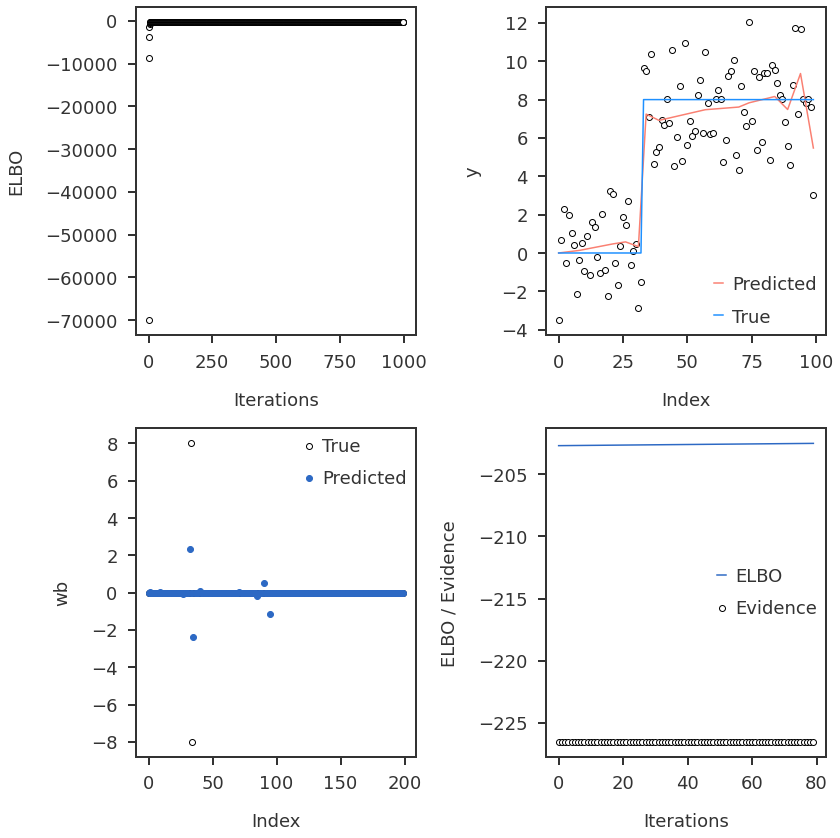

In [10]:
#collapse-hide
m4 = ebmr_WB(X, y, max_iter = 1000)

s2, sb2, sw2, mub, sigmab, muW, sigmaW, niter, elbo_path, mll_path = m4
bpred = mub * muW
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.arange(niter), elbo_path[1:], edgecolor = 'black', facecolor='white')
#ax1.plot(np.arange(niter), elbo_path[1:])
ax1.set_xlabel("Iterations")
ax1.set_ylabel("ELBO")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Index")
ax3.set_ylabel("wb")

nstep = min(80, niter - 1)
ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
ax4.legend()
ax4.set_xlabel("Iterations")
ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

### Variational approximation

Finally, I try to cast the problem in a variational approximation framework with a product of two normals. 

$p\left(\mathbf{y} \mid \mathbf{b}, \sigma^2\right) = N\left(\mathbf{y} \mid \mathbf{X}\mathbf{W}\mathbf{b}, \sigma^2 \mathbb{I}_n\right)$

$p\left(\mathbf{b} \mid \sigma_b^2\right) = N\left(\mathbf{b} \mid 0, \sigma_b^2 \mathbb{I}_p \right)$

$\displaystyle p\left(\mathbf{w} \mid \sigma_w^2\right) = \prod_{j=1}^{P} N\left(w_j \mid 0, \sigma_w^2 \mathbb{I}_p \right)$.

As before $\mathbf{W}$ is a $p \times p$ diagonal matrix whose diagonal elements are given by $w_j$. The vector of $\{w_j\}$ is denoted as $\mathbf{w}$. I used the following factorization:

$\displaystyle q\left(\mathbf{b}, \mathbf{W}\right) = q\left(\mathbf{b}\right) \prod_{j=1}^{P}q_j\left(w_j\right) $.

Here we can calulate the exact ELBO and derive the update equations. Derivations are still in my notebook. The updates are as follows:

$q\left(\mathbf{b}\right) = N\left( \mathbf{b} \mid \mathbf{m}, \mathbf{S}\right)$,

$q_j\left(w_j\right) = N\left( w_j \mid a_j, v_j^2 \right)$, 

$\displaystyle \mathbf{S} = \left[ \frac{1}{\sigma^2}\left(\mathbf{A}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{A} + \mathbf{\Lambda}_w\right) + \frac{1}{\sigma_b^2}\mathbb{I} \right]^{-1}$,

$\displaystyle \mathbf{m} = \frac{1}{\sigma^2} \mathbf{S}\mathbf{A}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{y}$,

$\mathbf{A}$ and  $\mathbf{\Lambda}_w$ are diagonal matrices whose diagonal elements are given by 

$\mathbf{A}_{jj} := a_j$, 

$(\mathbf{\Lambda}_w)_{jj} = (\mathbf{X}^{\mathsf{T}}\mathbf{X})_{jj}v_j^2$.

$\displaystyle v_j^2 = \left[ \frac{1}{\sigma^2} (\mathbf{X}^{\mathsf{T}}\mathbf{X})_{jj} \mathbf{R}_{jj} + \frac{1}{\sigma_w^2} \right]^{-1}$,

$\displaystyle a_j  = \frac{v_j^2}{\sigma^2} \left[m_j (\mathbf{X}^{\mathsf{T}}\mathbf{y})_j - \sum_{i=1\\{i\neq j}}^{P}{a_i (\mathbf{X}^{\mathsf{T}}\mathbf{X})_{ij} \mathbf{R}_{ij}} \right]$,

$\mathbf{R} := \mathbf{m}\mathbf{m}^{\mathsf{T}} + \mathbf{S}$. 

Finally, the updates of $\sigma^2$, $\sigma_b^2$ and $\sigma_w^2$ can be obtained by taking the derivative of $F(q(\mathbf{b}, \mathbf{W}))$ and setting them to 0 respectively. This yields

$\displaystyle \sigma^2 = \frac{1}{N} \left\{ \left\Vert \mathbf{y} - \mathbf{X}\mathbf{A}\mathbf{m} \right\Vert_{2}^{2} + \mathrm{Tr}\left(\left(\mathbf{A}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{A} + \mathbf{\Lambda}_w\right)\mathbf{S} \right) + \mathbf{m}^{\mathsf{T}}\mathbf{\Lambda}_w\mathbf{m}\right\}$, 

$\displaystyle \sigma_b^2 = \frac{1}{P} \mathrm{Tr}\left(\mathbf{m}\mathbf{m}^{\mathsf{T}} + \mathbf{S}\right)$ and

$\displaystyle \sigma_w^2 = \frac{1}{P} \sum_{j=1}^{P}\left(a_j^2 + v_j^2\right)$.


The iteration should stop when the ELBO $F(q(\mathbf{b}, \mathbf{w}))$ converges to a tolerance value (`tol`). But, there is some mistake in the ELBO calculation and currently, I am not using any convergence criteria.

$\displaystyle F(q) = P - \frac{N}{2}\ln(2\pi\sigma^2) - \frac{P}{2}\ln(\sigma_b^2) - \frac{P}{2}\ln(\sigma_w^2) - \frac{1}{2\sigma^2}\left\{\left\Vert \mathbf{y} - \mathbf{X}\mathbf{A}\mathbf{m} \right\Vert_2^2 + \mathrm{Tr}\left(\left(\mathbf{A}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{A} + \mathbf{\Lambda}_w\right)\mathbf{S} \right) + \mathbf{m}^{\mathsf{T}}\mathbf{\Lambda}_w\mathbf{m} \right\} - \frac{1}{2\sigma_b^2}\mathrm{Tr}\left(\mathbf{m}\mathbf{m}^{\mathsf{T}} + \mathbf{S}\right) - \frac{1}{2\sigma_w^2}\sum_{j=1}^{P}\left(a_j^2 + v_j^2\right) + \frac{1}{2}\ln\left\lvert\mathbf{S}\right\rvert + \frac{1}{2}\sum_{j=1}^{P}\ln{v_j^2}$

In [11]:
#collapse-hide

def grr_b(X, y, s2, sb2, Wbar, varWj, XTX, XTy):
    n, p = X.shape
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    VW = np.diag(XTX) * varWj
    
    sigmabinv = (WtXtXW + np.diag(VW) + np.eye(p) * s2 / sb2) / s2
    sigmab = np.linalg.inv(sigmabinv)
    mub = np.linalg.multi_dot([sigmab, W.T, XTy]) / s2
    
    XWmu = np.linalg.multi_dot([X, W, mub])
    mub2 = np.square(mub)
    s2 = (np.sum(np.square(y - XWmu)) \
          + np.dot((WtXtXW + np.diag(VW)), sigmab).trace() \
          + np.sum(mub2 * VW)) / n
    sb2 = (np.sum(mub2) + sigmab.trace()) / p
    return s2, sb2, mub, sigmab

def grr_W_old(X, y, s2, sw2, mub, sigmab, muWj, XTX, XTy):
    n, p = X.shape
    R = np.einsum('i,j->ij', mub, mub) + sigmab
    XTXRjj = np.array([XTX[j, j] * R[j, j] for j in range(p)])
    #wXTXRj = np.array([np.sum(muWj * XTX[:, j] * R[:, j]) - (muWj[j] * XTXRjj[j]) for j in range(p)])
    sigmaWj2 = 1 / ((XTXRjj / s2) + (1 / sw2))
    for j in range(p):
        wXTXRj = np.sum(muWj * XTX[:, j] * R[:, j]) - (muWj[j] * XTXRjj[j])
        muWj[j] = sigmaWj2[j] * (mub[j] * XTy[j] - 0.5 * wXTXRj) / s2
    sw2 = np.sum(np.square(muWj) + sigmaWj2) / p
    return sw2, muWj, sigmaWj2


def grr_W(X, y, s2, sw2, mub, sigmab, muWj, XTX, XTy):
    n, p = X.shape
    R = np.einsum('i,j->ij', mub, mub) + sigmab
    XTXRjj = np.diag(XTX) * np.diag(R)
    sigmaWj2inv = (XTXRjj / s2) + (1 / sw2)
    wXTXRj = np.array([np.sum(muWj * XTX[:, j] * R[:, j]) - (muWj[j] * XTXRjj[j]) for j in range(p)])
    sigmaWj2 = 1 / sigmaWj2inv
    muWj = sigmaWj2 * (mub * XTy - wXTXRj) / s2
    sw2 = np.sum(np.square(muWj) + sigmaWj2) / p
    #sigmaWj2 = np.zeros(p)
    return sw2, muWj, sigmaWj2
        

def elbo(X, y, s2, sb2, sw2, mub, sigmab, Wbar, varWj, XTX):
    '''
    Wbar is a vector which contains the diagonal elements of the diagonal matrix W
    W = diag_matrix(Wbar)
    Wbar = diag(W)
    --
    VW is a vector which contains the diagonal elements of the diagonal matrix V_w
    '''
    n, p = X.shape
    VW = np.diag(XTX) * varWj
    elbo = c_func(n, p, s2, sb2, sw2) \
           + h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW) \
           + h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varWj, VW)
    return elbo


def c_func(n, p, s2, sb2, sw2):
    val  =   p
    val += - 0.5 * n * np.log(2.0 * np.pi * s2)
    val += - 0.5 * p * np.log(sb2)
    val += - 0.5 * p * np.log(sw2)
    return val


def h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW):
    XWmu = np.linalg.multi_dot([X, np.diag(Wbar), mub])
    val1 = - (0.5 / s2) * np.sum(np.square(y - XWmu))
    val2 = - 0.5 * np.sum(np.square(mub) * ((VW / s2) + (1 / sb2)))
    val3 = - 0.5 * np.sum(np.square(Wbar)) / sw2
    val  = val1 + val2 + val3
    return val


def h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varWj, VW):
    (sign, logdetS) = np.linalg.slogdet(sigmab)
    logdetV = np.sum(np.log(varWj))
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    val  =   0.5 * logdetS + 0.5 * logdetV
    val += - 0.5 * np.trace(sigmab) / sb2 - 0.5 * np.sum(varWj) / sw2
    val += - 0.5 * np.dot(WtXtXW + np.diag(VW), sigmab).trace() / s2
    return val
    

def ebmr_WB(X, y,
            s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
            binit = None, winit = None,
            max_iter = 1000, tol = 1e-8
           ):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    n_samples, n_features = X.shape
    elbo_path = np.zeros(max_iter + 1)
    mll_path = np.zeros(max_iter + 1)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    sw2 = sw2_init
    mub = np.ones(n_features)  if binit is None else binit
    muWj = np.ones(n_features) if winit is None else winit
    sigmab = np.zeros((n_features, n_features))
    sigmaWj2 = np.zeros(n_features)
    elbo_path[0] = -np.inf
    mll_path[0] = -np.inf
    
    for itn in range(1, max_iter + 1):
        '''
        GRR for b
        '''
        s2, sb2, mub, sigmab = grr_b(X, y, s2, sb2, muWj, sigmaWj2, XTX, XTy)
        
        '''
        GRR for W
        '''
        sw2, muWj, sigmaWj2  = grr_W(X, y, s2, sw2, mub, sigmab, muWj, XTX, XTy)
        
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = elbo(X, y, s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, XTX)
        mll_path[itn] = ridge_mll(X, y, s2, sb2, muWj)
        if elbo_path[itn] - elbo_path[itn - 1] < tol: break
        #if mll_path[itn] - mll_path[itn - 1] < tol: break
    return s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, niter, elbo_path[:niter + 1], mll_path[:niter + 1]

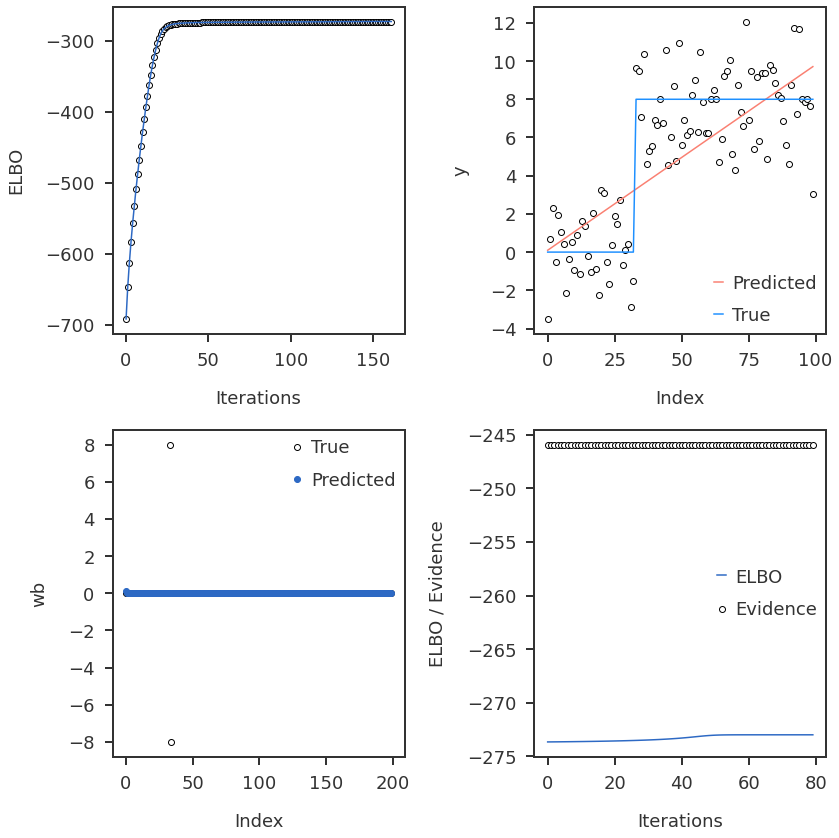

In [12]:
#collapse-hide
m5 = ebmr_WB(X, y)

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m5
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.arange(niter-1), elbo_path[2:], edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter-1), elbo_path[2:])
ax1.set_xlabel("Iterations")
ax1.set_ylabel("ELBO")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Index")
ax3.set_ylabel("wb")

nstep = min(80, niter - 2)
ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
ax4.legend()
ax4.set_xlabel("Iterations")
ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()